# Quickstart

Showcase for how this package can be used.

## Example data

Let's start by importing the package and getting some mock example timeseries in hourly resolution for a certain customer portfolio.

In [1]:
import portfolyo as pf
import pandas as pd
index = pd.date_range('2024', freq='H', periods=8784, tz='Europe/Berlin')

# Creating market prices (here: forward price curve) timeseries.
ts_prices = pf.dev.p_marketprices(index, avg=200)

# Creating portfolio offtake timeseries.
ts_offtake = -1 * pf.dev.w_offtake(index, avg=50)
# Creating portfolio sourced volume and prices timeseries (of quarter-products).
ts_sourced_power, ts_sourced_price = pf.dev.wp_sourced(ts_offtake, 'QS', 0.3, p_avg=120)

## Portfolio lines

By turning the timeseries into 3 "portfolio lines"...

In [2]:
hpfc = pf.PfLine({'p': ts_prices}) # price-only
offtake = pf.PfLine({'w': ts_offtake}) # volume-only
sourced = pf.PfLine({'w': ts_sourced_power, 'p': ts_sourced_price}) # price-and-volume

...it becomes easier to do common operations like plotting:

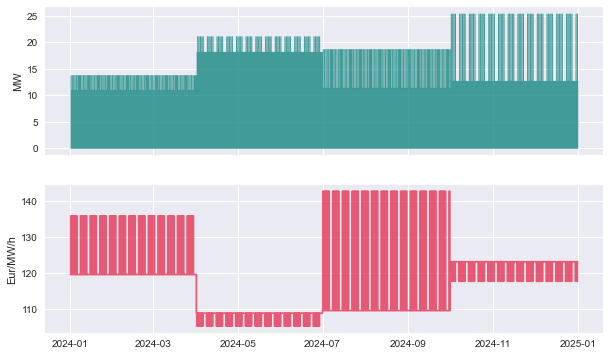

In [3]:
sourced.plot();

...aggregating:

In [4]:
sourced.asfreq('MS')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-01 00:00:00+01:00         freq: <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         12.8       9 543      124.82     1 191 148
2024-02-01 00:00:00 +0100         12.9       8 944      124.69     1 115 235
2024-03-01 00:00:00 +0100         12.9       9 595      124.34     1 193 117
2024-04-01 00:00:00 +0200         19.3      13 916      107.40     1 494 558
2024-05-01 00:00:00 +0200         19.3      14 390      107.38     1 545 151
2024-06-01 00:00:00 +0200         19.2      13 846      107.52     1 488 749
2024-07-01 00:00:00 +0200         16.1      11 953      118.36     1 414 741
2024-08-01 00:00:00 +0200         16.2      12 040      117.92     1 419 781
2024-09-01 00:0

...or decomposing into peak- and offpeak values:

In [5]:
sourced.po('QS').pint.dequantify()  # .pint.dequantify() to show units in column header

peak                                       \
                          duration          w             q           p   
unit                             h         MW          MW·h     Eur/MWh   
2024-01-01 00:00:00+01:00    780.0  11.081353   8643.455578  135.900870   
2024-04-01 00:00:00+02:00    780.0  21.178663  16519.357285  105.250543   
2024-07-01 00:00:00+02:00    792.0  11.468930   9083.392822  142.762599   
2024-10-01 00:00:00+02:00    792.0  25.478209  20178.741685  117.719131   

                                         offpeak                           \
                                      r duration          w             q   
unit                                Eur        h         MW          MW·h   
2024-01-01 00:00:00+01:00  1.174653e+06   1403.0  13.855152  19438.777701   
2024-04-01 00:00:00+02:00  1.738671e+06   1404.0  18.257125  25633.003537   
2024-07-01 00:00:00+02:00  1.296769e+06   1416.0  18.776431  26587.426350   
2024-10-01 00:00:00+02:00  2.375424e+06   1417.0  12.773542  18100.109647   

                                                     
                                    p             r  
unit                          Eur/MWh           Eur  
2024-01-01 00:00:00+01:00  119.598378  2.324846e+06  
2024-04-01 00:00:00+02:00  108.835747  2.789787e+06  
2024-07-01 00:00:00+02:00  109.570527  2.913198e+06  
2024-10-01 00:00:00+02:00  123.160695  2.229222e+06

## Portfolio state

We can do even more useful analyses by combining the portfolio lines for offtake, sourced, and market prices into a single "portfolio state":

In [6]:
pfs = pf.PfState(offtake, hpfc, sourced)

pfs

PfState object.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-31 23:00:00+01:00         freq: <Hour> (8784 datapoints)
                                                w           q           p             r
                                               MW         MWh     Eur/MWh           Eur
──────── offtake
           2024-01-01 00:00:00 +0100        -55.4         -55                          
           2024-01-01 01:00:00 +0100        -52.4         -52                          
           ..                                  ..          ..          ..            ..
           2024-12-31 22:00:00 +0100        -67.6         -68                          
           2024-12-31 23:00:00 +0100        -62.7         -63                          
─●────── pnl_cost
 │         2024-01-01 00:00:00 +0100         55.4          55      202.86        11 242
 │         2024-01-01 01:00:00 +0100         52.4          52      191.44        10 

This object can also be resampled to other frequencies:

In [7]:
pfs_months = pfs.asfreq('MS')

We can see how much of the offtake volume is still unsourced, and how much we expect to pay for it, as a portfolio line. We can obtain it in the original frequency with `pfs.unsourced`, or in monthly frequency with `pfs_monthly.unsourced`. We can of course also chain the methods:

In [8]:
pfs.asfreq('MS').unsourced  # or: pfs.unsourced.asfreq('MS')

PfLine object with price and volume information.
. Timestamps: first: 2024-01-01 00:00:00+01:00     timezone: Europe/Berlin
               last: 2024-12-01 00:00:00+01:00         freq: <MonthBegin> (12 datapoints)
                                     w           q           p             r
                                    MW         MWh     Eur/MWh           Eur

2024-01-01 00:00:00 +0100         51.7      38 491      252.13     9 704 977
2024-02-01 00:00:00 +0100         50.4      35 046      237.25     8 314 452
2024-03-01 00:00:00 +0100         46.4      34 509      209.52     7 230 076
2024-04-01 00:00:00 +0200         35.5      25 534      182.02     4 647 620
2024-05-01 00:00:00 +0200         30.6      22 732      154.29     3 507 257
2024-06-01 00:00:00 +0200         26.5      19 046      133.56     2 543 672
2024-07-01 00:00:00 +0200         28.7      21 378      144.12     3 080 897
2024-08-01 00:00:00 +0200         29.7      22 087      153.11     3 381 756
2024-09-01 00:0

Plotting is also possible:

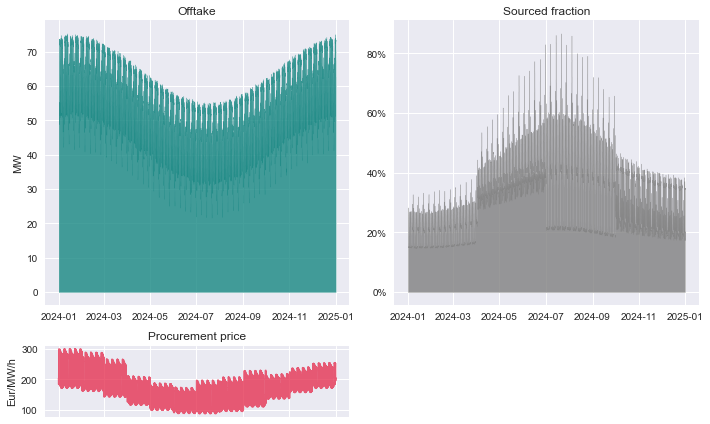

In [9]:
pfs.plot();

We can see how much it would cost to perfectly hedge the entire offtake volume, based on what has already been sourced (and its price) and what is still unsourced (valued at market prices). This is available at `pfl.pnl_cost`. Let's look at this, graphically, in month values:

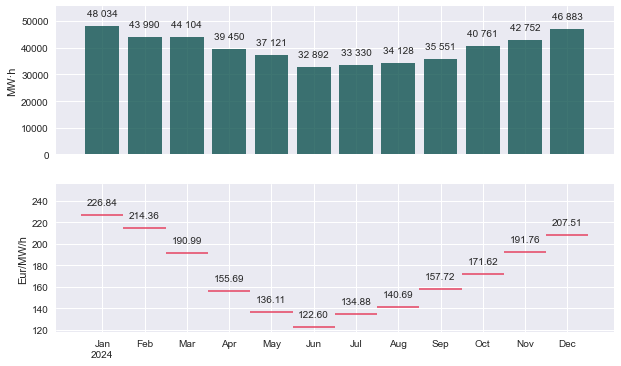

In [10]:
pfs.pnl_cost.asfreq("MS").plot();

On average, only about 30% of the portfolio has currently been hedged:

In [11]:
pfs.asfreq('MS').sourcedfraction  # not pfs.sourcedfraction.asfreq("MS") !
# (.sourcedfraction is a pandas Series, which does not average when applying .asfreq("MS"))

2024-01-01 00:00:00+01:00    0.19866528809724712
2024-02-01 00:00:00+01:00    0.20332342510651685
2024-03-01 00:00:00+01:00    0.21756287562872878
2024-04-01 00:00:00+02:00    0.35275818486460725
2024-05-01 00:00:00+02:00     0.3876384749245314
2024-06-01 00:00:00+02:00     0.4209619008568723
2024-07-01 00:00:00+02:00     0.3586151610567345
2024-08-01 00:00:00+02:00     0.3528072944451228
2024-09-01 00:00:00+02:00     0.3284752689185908
2024-10-01 00:00:00+02:00    0.31948738180588887
2024-11-01 00:00:00+01:00      0.290008101241896
2024-12-01 00:00:00+01:00     0.2742463341431951
Freq: MS, Name: fraction, dtype: pint[]

This means that an increase in the market prices will have a relatively large impact, especially in the months with a low sourced fraction. Let's verify that. 

First, we create a new price curve, and then create a new portfolio state with it. Then, we again look at the ``.pnl_cost`` property, to see the new procurement prices:

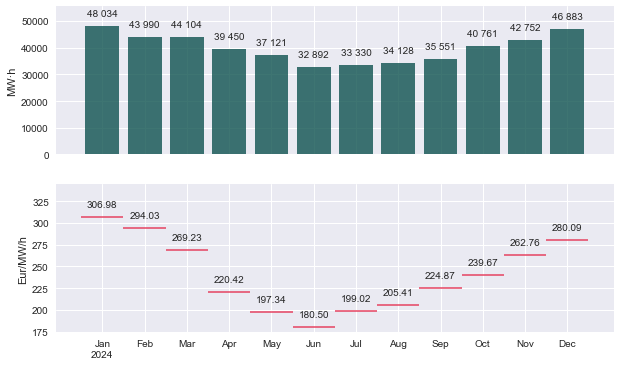

In [12]:
hpfc2 = hpfc + pf.Q_(100, "Eur/MWh")
pfs2 = pfs.set_unsourcedprice(hpfc2)
pfs2.pnl_cost.asfreq("MS").plot();

We could even explicitly calculate the monthly price increases:

In [13]:
pfs2.asfreq("MS").pnl_cost.p - pfs.asfreq("MS").pnl_cost.p

2024-01-01 00:00:00+01:00     80.13347119027526
2024-02-01 00:00:00+01:00     79.66765748934816
2024-03-01 00:00:00+01:00     78.24371243712721
2024-04-01 00:00:00+02:00     64.72418151353924
2024-05-01 00:00:00+02:00     61.23615250754713
2024-06-01 00:00:00+02:00    57.903809914312674
2024-07-01 00:00:00+02:00     64.13848389432627
2024-08-01 00:00:00+02:00     64.71927055548758
2024-09-01 00:00:00+02:00     67.15247310814101
2024-10-01 00:00:00+02:00     68.05126181941145
2024-11-01 00:00:00+01:00     70.99918987581026
2024-12-01 00:00:00+01:00     72.57536658568074
Freq: MS, Name: p, dtype: pint[Eur/MWh]

Indeed, the 100 Eur/MWh across-the-board market price increase has impacted the months exactly in proportion to the fraction that is still unsourced. So, a month that is 60% hedged sees a 40% * 100 Eur/MWh impact in its procurement price.

That's it for this quick introduction. Have a look at the more in-depth [tutorial](part1.ipynb) or the more systematic documentation of the [PfLine](../core/pfline.rst) or [PfState](../core/pfstate.rst) classes.